In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet34
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from PIL import Image

# Монтуємо Google Drive
drive.mount('/content/drive')

# Шлях до папки з даними на Google Drive
data_dir = '/content/drive/MyDrive/data'

# Функція для конвертації зображень з палітрою в RGB
def convert_to_rgb(image):
    return image.convert('RGB')

# Розширений набір трансформацій для аугментації даних
transform_train = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 32

# Завантажуємо тренувальний датасет
trainset = ImageFolder(root='/content/drive/My Drive/data/train', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Завантажуємо тестовий датасет
testset = ImageFolder(root='/content/drive/My Drive/data/test', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Отримуємо назви класів
classes = trainset.classes

# Завантажуємо попередньо навчену модель
model = resnet34(pretrained=True)

# Заморожуємо параметри моделі
for param in model.parameters():
    param.requires_grad = False

# Замінюємо останній шар на новий для нашої задачі
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(classes))
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Зважена функція втрат
class_weights = torch.tensor([1.0, 2.0, 1.0]).to(device)  # Збільшуємо вагу для класу машин
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

# Функція для тренування моделі
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(trainset)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

        scheduler.step(epoch_acc)

    return model

# Функція для показу зображення
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Отримуємо випадкові тренувальні зображення
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Показуємо зображення
imshow(torchvision.utils.make_grid(images[:5]))
# Виводимо мітки
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

# Тренуємо модель
model = train_model(model, criterion, optimizer, scheduler, num_epochs=50)

# Зберігаємо модель
torch.save(model.state_dict(), 'custom_resnet.pth')

# Оцінюємо модель
model.eval()
correct = 0
total = 0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print(f'Accuracy of the network on the test images: {100 * correct / total:.1f} %')

for i in range(len(classes)):
    print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.1f}%')

print(f'Using device: {device}')

print("Showing 5 sample predictions:")

# Отримуємо випадкові тестові зображення
dataiter = iter(testloader)
images, labels = next(dataiter)

# Показуємо зображення
imshow(torchvision.utils.make_grid(images[:5]))

# Виводимо справжні мітки
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

# Отримуємо передбачення моделі
outputs = model(images[:5].to(device))
_, predicted = torch.max(outputs, 1)

# Виводимо передбачені мітки
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(5)))

ModuleNotFoundError: No module named 'Pytorch'

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


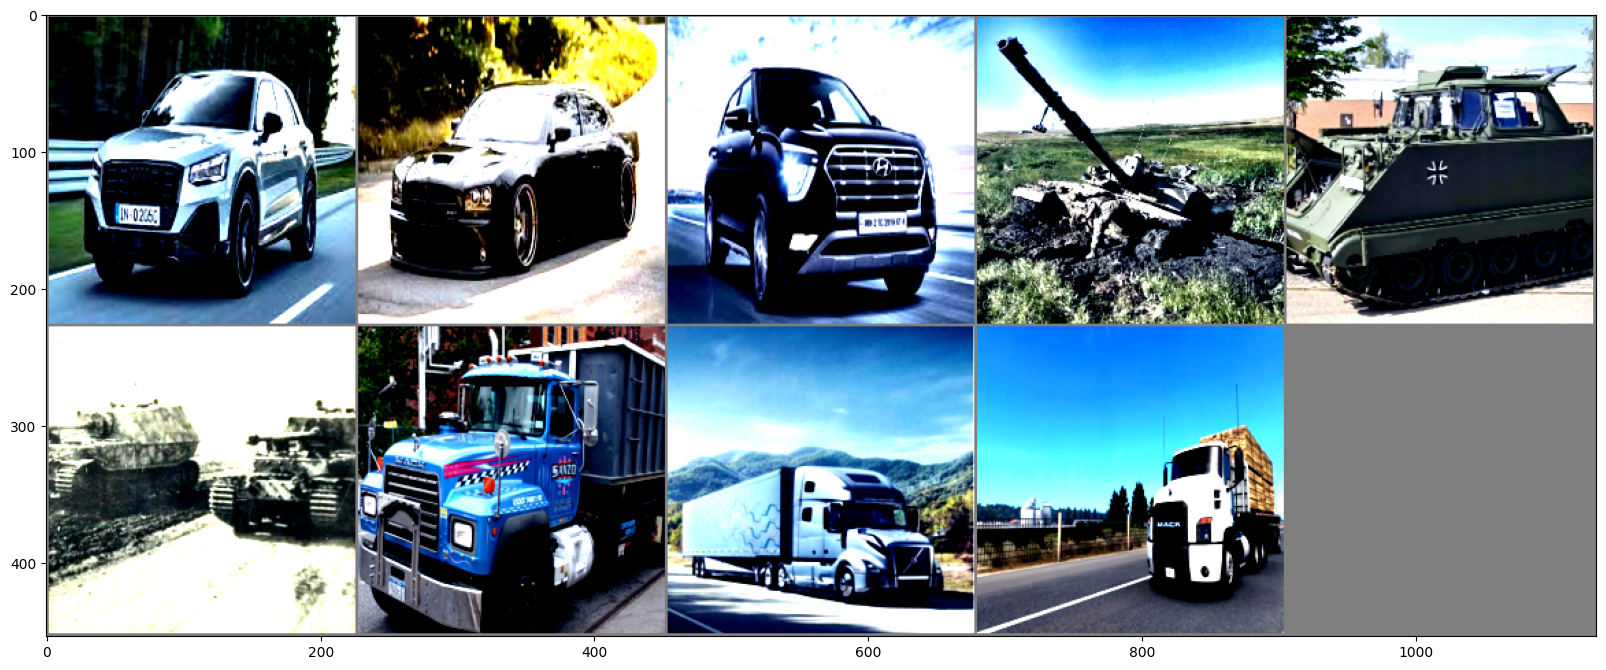

GroundTruth:  car   car   car   tank  tank  tank  truck truck truck
Predicted:  car   car   car   tank  tank  tank  truck truck truck
Accuracy for these 10 images: 100.0%


In [ ]:
# Функція для отримання зображень різних класів
def get_images_of_different_classes(dataloader, num_images, classes):
    images = []
    labels = []
    class_count = {i: 0 for i in range(len(classes))}

    for batch in dataloader:
        batch_images, batch_labels = batch
        for img, label in zip(batch_images, batch_labels):
            if class_count[label.item()] < num_images // len(classes):
                images.append(img)
                labels.append(label)
                class_count[label.item()] += 1

            if len(images) == num_images:
                return torch.stack(images), torch.stack(labels)

    return torch.stack(images), torch.stack(labels)

# Отримуємо 10 зображень різних класів
images, labels = get_images_of_different_classes(testloader, 10, classes)

# Показуємо зображення
plt.figure(figsize=(20, 10))
imshow(torchvision.utils.make_grid(images, nrow=5))

# Виводимо справжні мітки
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(10)))

# Отримуємо передбачення моделі
model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

# Виводимо передбачені мітки
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(10)))

# Виводимо точність для цих 10 зображень
correct = (predicted == labels.to(device)).sum().item()
print(f'Accuracy for these 10 images: {100 * correct / 10:.1f}%')